In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
import joblib

tf.random.set_seed(1)
np.random.seed(1)

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = Path("drive/My Drive/airnology/train.csv")
train = pd.read_csv(train_path, parse_dates=['datetime_iso'], index_col='datetime_iso')
train.head()

,datetime,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
datetime_iso,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,283996800,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1979-01-01 01:00:00+00:00,284000400,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
1979-01-01 02:00:00+00:00,284004000,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
1979-01-01 03:00:00+00:00,284007600,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
1979-01-01 04:00:00+00:00,284011200,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341880 entries, 1979-01-01 00:00:00+00:00 to 2017-12-31 23:00:00+00:00
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   datetime    341880 non-null  int64 
 1   time-zone   341880 non-null  int64 
 2   temp        341880 non-null  object
 3   visibility  51112 non-null   object
 4   d_point     341880 non-null  object
 5   feels       341880 non-null  object
 6   min_temp    341880 non-null  object
 7   max_temp    341880 non-null  object
 8   prssr       341880 non-null  object
 9   sea_level   192964 non-null  object
 10  grnd_level  192919 non-null  object
 11  hum         341880 non-null  object
 12  wind_spd    341880 non-null  object
 13  wind_deg    341880 non-null  object
 14  rain_1h     341880 non-null  object
 15  rain_3h     192329 non-null  object
 16  snow_1h     192696 non-null  object
 17  snow_3h     192699 non-null  object
 18  clouds      341880

# CLEANING



In [ ]:
train.drop(['datetime',"time-zone"], axis=1, inplace=True)

### visibility

[nan 'unidentified' ' ' '-1m' 'unrecognized' 'unknown' '-1 km' '-1'
 'empty' 'undefined' '-1km' '-1 m' 'missing']


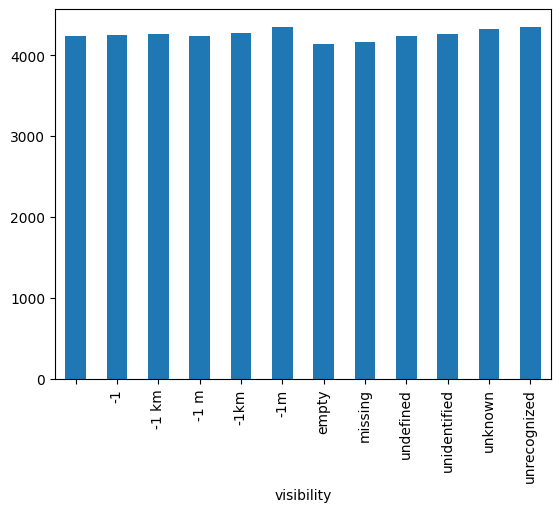

In [ ]:
train.groupby('visibility').size().plot(kind='bar')
print(train['visibility'].unique())

In [ ]:
# memperbaiki kolom 'visibility'
replace_dict = {
    '-1 m': -1,
    '-1': -1,
    '-1m': -1,
    '-1km': -1000,
    '-1 km': -1000
}
train['visibility'] = train['visibility'].replace(replace_dict)
train['visibility'] = train['visibility'].replace({'nan': np.nan, 'unidentified': 0, ' ': 0, 'unrecognized': 0, 'unknown': 0, 'empty': 0, 'undefined': 0, 'missing': 0})
train['visibility'] = train['visibility'].astype(float)
train['visibility'].fillna(0, inplace=True)
train['visibility'] = train['visibility'].astype(int)

[    0    -1 -1000]


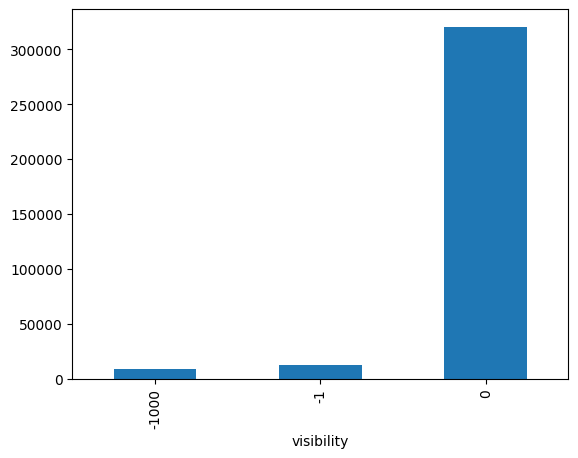

In [ ]:
train.groupby('visibility').size().plot(kind='bar')
print(train['visibility'].unique())

### sea_level

['undetermined' nan 'unsettled' 'unestablished' '-1' 'not recorded'
 'unknown' 'not_recorded' 'not-recorded' 'unspecified']


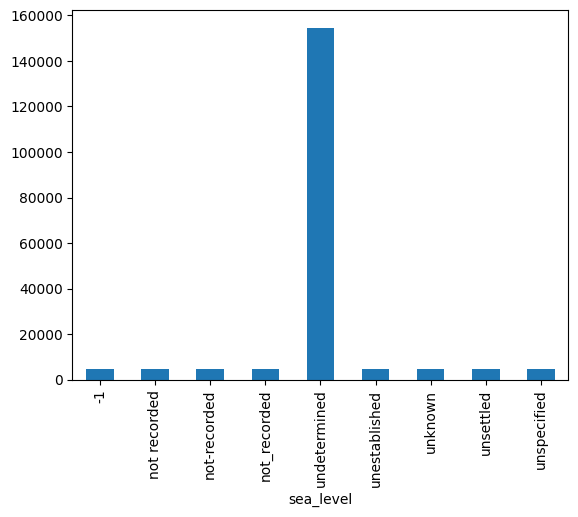

In [ ]:
train.groupby('sea_level').size().plot(kind='bar')
print(train['sea_level'].unique())

In [ ]:
# memperbaiki kolom 'sea_level'
train['sea_level'] = train['sea_level'].replace({'nan': np.nan, 'undetermined': 0, 'unsettled': 0, 'unestablished': 0, 'unknown': 0, 'not recorded': 0, 'not_recorded': 0, 'not-recorded': 0, 'unspecified': 0})
train['sea_level'] = train['sea_level'].astype(float)
train['sea_level'].fillna(0, inplace=True)
train['sea_level'] = train['sea_level'].astype(int)

[ 0 -1]


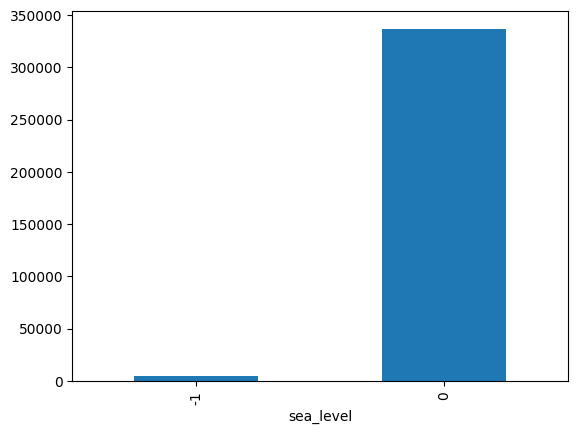

In [ ]:
train.groupby('sea_level').size().plot(kind='bar')
print(train['sea_level'].unique())

### grnd_level

[nan 'undetermined' 'not recorded' 'unspecified' 'unknown' 'not_recorded'
 '-1' 'unestablished' 'not-recorded' 'unsettled']


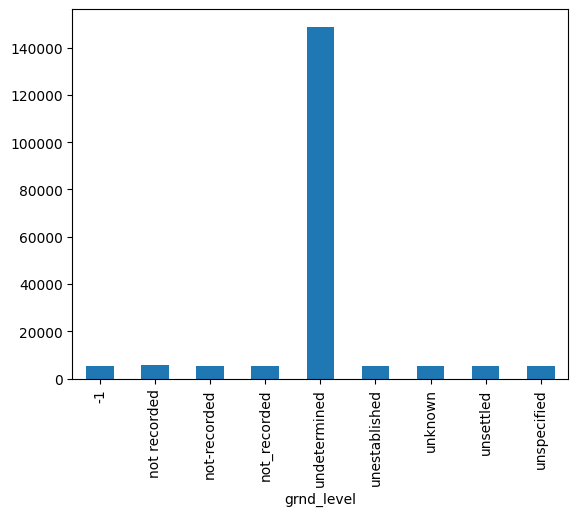

In [ ]:
train.groupby('grnd_level').size().plot(kind='bar')
print(train['grnd_level'].unique())

In [ ]:
# memperbaiki kolom 'grnd_level'
train['grnd_level'] = train['grnd_level'].replace({'nan': np.nan, 'undetermined': 0, 'unsettled': 0, 'unestablished': 0, 'unknown': 0, 'not recorded': 0, 'not_recorded': 0, 'not-recorded': 0, 'unspecified': 0})
train['grnd_level'] = train['grnd_level'].astype(float)
train['grnd_level'].fillna(0, inplace=True)
train['grnd_level'] = train['grnd_level'].astype(int)

[ 0 -1]


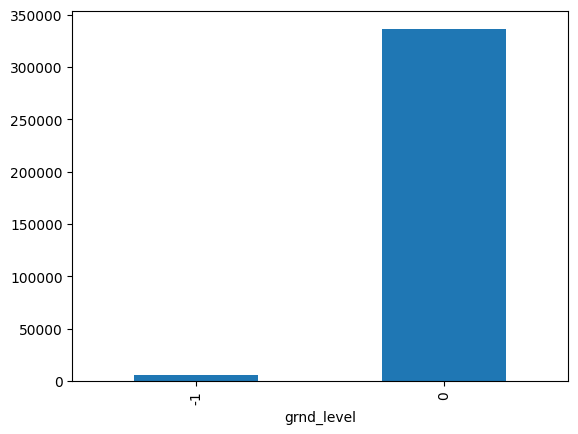

In [ ]:
train.groupby('grnd_level').size().plot(kind='bar')
print(train['grnd_level'].unique())

### rain_1h

In [ ]:
print(train['rain_1h'].unique())

['zero' '0' '0.13' ... '8.21 mm' '9.53' '9.16 mm']


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'rain_1h' dan mengonversi ke float
train['rain_1h'] = train['rain_1h'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['rain_1h'] = train['rain_1h'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['rain_1h'].unique())

[0.   0.13 0.34 ... 8.21 9.53 9.16]


### temp

In [ ]:
print(train['temp'].unique())

['24.75 Celcius' '24.58 C' '26.6 Celcius' ... '136.06 °C' '33.48 Celcius'
 '34.32 C']


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'temp' dan mengonversi ke float
train['temp'] = train['temp'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['temp'] = train['temp'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['temp'].unique())

[ 24.75  24.58  26.6  ... 158.6  159.75  34.32]


### d_point

In [ ]:
print(train['d_point'].unique())

['23.89  C' '23.73 C' '24.06 C' ... '28.13 C' '28.1 Celcius' '126.76°C']


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'd_point' dan mengonversi ke float
train['d_point'] = train['d_point'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['d_point'] = train['d_point'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['d_point'].unique())

[23.89 23.73 24.06 ... 28.08 28.69 28.53]


### feels

In [ ]:
print(train['feels'].unique())

['25.76 C' '25.57 C' '26.6 C' ... '153.97 C' '189.53 C' '33.69 Celcius']


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'feels' dan mengonversi ke float
train['feels'] = train['feels'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['feels'] = train['feels'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['feels'].unique())

[ 25.76  25.57  26.6  ...  41.32 187.52 189.53]


### min_temp

In [ ]:
print(train['min_temp'].unique())

['24.28' '23.99 C' '26.1 C' ... '127.26  C' '143.15 °C' '131.18°C']


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'min_temp' dan mengonversi ke float
train['min_temp'] = train['min_temp'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['min_temp'] = train['min_temp'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['min_temp'].unique())

[ 24.28  23.99  26.1  ... 149.19 146.78 148.74]


### max_temp

In [ ]:
print(train['max_temp'].unique())

['25.22°C' '25.26 C' '27.39' ... '34.34 Celcius' '177.66' '126.96  C']


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'max_temp' dan mengonversi ke float
train['max_temp'] = train['max_temp'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['max_temp'] = train['max_temp'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['max_temp'].unique())

[ 25.22  25.26  27.39 ...  35.4  169.91 177.66]


### prssr

In [ ]:
print(train['prssr'].unique())

['1012' '1011' '1010' '1010.0 hPa' '1009' '1012.0hPa' '1012.0 hPa'
 '1012.0 hPa.' '1013.0 hPa' '1013' '1011.0 hPa.' '1013.0hPa' '1011.0 hPa'
 '1008' '1009.0 hPa' '1011.0hPa' '5080.3' '1007' '1008.0 hPa' '1008.0hPa'
 '1007.0 hPa.' '5090.36' '5085.33' '1013.0 hPa.' '1014.0 hPa.' '1009.0hPa'
 '1009.0 hPa.' '1010.0 hPa.' '1007.0 hPa' '1008.0 hPa.' '5090.36 hPa.'
 '5085.33 hPa' '1010.0hPa' '1014' '1015.0 hPa' '1015' '1014.0 hPa'
 '1015.0 hPa.' '5095.39' '1014.0hPa' '1007.0hPa' '5060.18' '1006' '1005'
 '1006.0 hPa.' '1006.0 hPa' '5070.24' '5075.27' '5080.3hPa' '5075.27 hPa'
 '5070.24 hPa' '5065.21hPa' '1006.0hPa' '5065.21' '5080.3 hPa'
 '1005.0 hPa' '1005.0 hPa.' '5085.33hPa' '5075.27 hPa.' '5090.36 hPa'
 '1004' '1005.0hPa' '5070.24 hPa.' '5100.42 hPa' '5080.3 hPa.'
 '5085.33 hPa.' '5060.18 hPa' '5055.15' '5100.42' '1016' '1015.0hPa'
 '5065.21 hPa.' '5065.21 hPa' '5090.36hPa' '1004.0 hPa.' '5075.27hPa'
 '1004.0 hPa' '5105.45 hPa' '1016.0hPa' '1016.0 hPa.' '5100.42 hPa.'
 '1004.0hPa' '5055.15

In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'prssr' dan mengonversi ke float
train['prssr'] = train['prssr'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['prssr'] = train['prssr'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['prssr'].unique())

[1012.   1011.   1010.   1009.   1013.   1008.   5080.3  1007.   5090.36
 5085.33 1014.   1015.   5095.39 5060.18 1006.   1005.   5070.24 5075.27
 5065.21 1004.   5100.42 5055.15 1016.   5105.45 1017.   1003.   1002.
 5050.12 5045.09 5115.51 1001.  ]


### hum

In [ ]:
print(train['hum'].unique())

['95' '86' '84' '87' '83' '77' '85' '92' '98' '99' '99.00%' '497.97' '100'
 '98.00%' '95.00%' '90' '89' '87.00%' '89.00%' '88' '94' '96' '97' '93'
 '73' '362.16' '70' '74' '96.00%' '76' '71' '66' '80' '81' '69.00%' '79'
 '91' '82' '67.00%' '82.00%' '91.00%' '93.00%' '97.00%' '94.00%' '88.00%'
 '78' '75' '100.00%' '492.94' '73.00%' '72' '90.00%' '417.49' '79.00%'
 '69' '477.85%' '72.00%' '71.00%' '74.00%' '467.79' '70.00%' '442.64' '64'
 '61' '60' '63' '84.00%' '80.00%' '377.25' '67' '65' '92.00%' '78.00%'
 '62' '58' '56' '55' '57' '66.00%' '68' '81.00%' '76.00%' '68.00%'
 '462.76' '487.91' '83.00%' '482.88' '503' '412.46' '477.85' '75.00%'
 '85.00%' '472.82' '59' '59.00%' '86.00%' '382.28' '482.88%' '77.00%'
 '402.4' '497.97%' '492.94%' '452.70%' '462.76%' '387.31%' '65.00%'
 '60.00%' '352.1' '457.73' '447.67%' '392.34' '427.55' '452.7' '447.67'
 '437.61' '367.19' '467.79%' '62.00%' '362.16%' '407.43%' '54' '64.00%'
 '53' '56.00%' '392.34%' '357.13' '422.52' '397.37%' '487.91%' '387.31

In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'hum' dan mengonversi ke float
train['hum'] = train['hum'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['hum'] = train['hum'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['hum'].unique())

[ 95.    86.    84.    87.    83.    77.    85.    92.    98.    99.
 497.97 100.    90.    89.    88.    94.    96.    97.    93.    73.
 362.16  70.    74.    76.    71.    66.    80.    81.    69.    79.
  91.    82.    67.    78.    75.   492.94  72.   417.49 477.85 467.79
 442.64  64.    61.    60.    63.   377.25  65.    62.    58.    56.
  55.    57.    68.   462.76 487.91 482.88 503.   412.46 472.82  59.
 382.28 402.4  452.7  387.31 352.1  457.73 447.67 392.34 427.55 437.61
 367.19 407.43  54.    53.   357.13 422.52 397.37 342.04 337.01 372.22
 347.07 432.58 331.98 326.95  51.   321.92 271.62 276.65 316.89  52.
  50.   306.83  47.    46.   296.77  44.    48.    45.    49.   236.41
 221.32  43.    42.    40.    41.   286.71 256.53  39.   301.8  246.47
 311.86 281.68 291.74 261.56 266.59  35.    33.    34.    38.    37.
  36.   176.05  32.    29.   196.17 201.2  171.02]


### wind_spd

In [ ]:
print(train['wind_spd'].unique())

['0.82' '0.96 m/s' '1.22 m/s' ... '12.22m/s' '8.5m/s' '20.02m/s']


In [ ]:
# Menggunakan ekspresi reguler untuk mengambil angka dari kolom 'wind_spd' dan mengonversi ke float
train['wind_spd'] = train['wind_spd'].apply(lambda x: re.search(r'[\d.]+', x).group() if re.search(r'[\d.]+', x) else '0')
train['wind_spd'] = train['wind_spd'].astype(float)

In [ ]:
print(train['wind_spd'].unique())

[8.200e-01 9.600e-01 1.220e+00 1.080e+00 8.600e-01 8.400e-01 7.100e-01
 6.200e-01 4.400e-01 6.300e-01 7.800e-01 6.900e-01 1.010e+00 8.000e-01
 9.000e-01 9.200e-01 6.600e-01 7.700e-01 1.000e+00 6.100e-01 6.800e-01
 3.700e-01 3.100e-01 5.400e-01 7.500e-01 1.540e+00 4.900e-01 4.000e-02
 7.200e-01 1.350e+00 8.500e-01 6.700e-01 5.200e-01 8.700e-01 5.800e-01
 5.900e-01 1.600e-01 2.000e-01 4.100e-01 1.760e+00 1.090e+00 8.900e-01
 1.040e+00 4.800e-01 1.210e+00 1.260e+00 1.430e+00 8.800e-01 1.020e+00
 1.110e+00 1.580e+00 9.800e-01 2.800e-01 2.700e-01 9.700e-01 4.500e-01
 6.000e-02 1.410e+00 1.480e+00 1.230e+00 1.190e+00 1.200e+00 7.600e-01
 1.060e+00 9.900e-01 1.170e+00 1.590e+00 1.300e+00 9.100e-01 6.500e-01
 1.240e+00 1.130e+00 1.520e+00 1.340e+00 1.700e+00 1.930e+00 1.750e+00
 4.000e-01 1.050e+00 7.300e-01 1.370e+00 1.100e+00 1.650e+00 1.450e+00
 1.330e+00 1.250e+00 7.900e-01 3.800e-01 1.280e+00 9.300e-01 1.570e+00
 1.560e+00 1.720e+00 1.640e+00 1.160e+00 1.440e+00 1.800e-01 5.700e-01
 1.070

### wind_deg

In [ ]:
print(train['wind_deg'].unique())

['320.0 °' '338.0°' '339.0°' ... '503.0°' '286.71°' '437.61 °']


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'wind_deg' dan mengonversi ke float
train['wind_deg'] = train['wind_deg'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['wind_deg'] = train['wind_deg'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['wind_deg'].unique())

[3.20000e+02 3.38000e+02 3.39000e+02 3.42000e+02 3.36000e+02 7.00000e+00
 3.09000e+02 2.91000e+02 2.85000e+02 2.94000e+02 3.60000e+01 1.00000e+01
 3.29000e+02 3.25000e+02 3.05000e+02 3.01000e+02 2.96000e+02 3.11000e+02
 2.81000e+02 2.67000e+02 2.89000e+02 2.87000e+02 3.26000e+02 3.24000e+02
 2.93000e+02 2.45000e+02 2.12000e+02 2.01000e+02 2.07000e+02 2.22000e+02
 2.03000e+02 2.82000e+02 3.50000e+01 4.30000e+01 4.60000e+01 4.80000e+01
 2.70000e+01 3.46000e+02 3.40000e+02 3.22000e+02 3.17000e+02 3.08000e+02
 3.19000e+02 3.27000e+02 3.47000e+02 3.00000e+01 6.00000e+01 1.70000e+02
 1.86000e+02 1.57000e+02 1.56000e+02 1.64000e+02 2.47000e+02 2.27000e+02
 2.37000e+02 2.23000e+02 2.51000e+02 2.72000e+02 3.23000e+02 3.37000e+02
 3.33000e+02 1.63475e+03 3.31000e+02 3.35000e+02 3.28000e+02 3.32000e+02
 8.90000e+01 1.26000e+02 1.39000e+02 1.23000e+02 8.40000e+01 6.80000e+01
 1.46000e+02 1.38000e+02 3.02000e+02 3.15000e+02 3.18000e+02 3.10000e+02
 3.14000e+02 3.12000e+02 2.55000e+02 1.33000e+02 8.

### rain_3h

In [ ]:
print(train['rain_3h'].unique())

['0' 'volume:zero' 'nol' nan 'zero' '0 mm' '0 milimeter' 'no_rain'
 'no-rain' 'volume:0' '0mm']


In [ ]:
print(train['snow_1h'].unique())

[nan '0' 'nol' 'volume:zero' '0mm' '0 mm' 'volume:0' 'zero' '0 milimeter'
 'no-snow' 'no_snow']


In [ ]:
print(train['snow_3h'].unique())

[nan '0' 'no-snow' '0 mm' 'zero' 'volume:0' '0mm' 'no_snow' 'volume:zero'
 '0 milimeter' 'nol']


disini dapat terlihat bahwa pada column 'rain_3h' 'snow_1h' dan 'snow_3h' tidak ada value yang berarti selain 0 sehingga column ini dapat drop

In [ ]:
# drop column 'rain_3h' 'snow_1h' dan 'snow_3h'
train.drop(['rain_3h', 'snow_1h', 'snow_3h'], axis=1, inplace=True)

### clouds

In [ ]:
print(train['clouds'].unique())

['100' '99' '94' '95' '97' '92' '87' '100.00%' '98' '99.00%' '91.00%' '78'
 '80' '85' '91' '93' '77' '82.00%' '74' '45.00%' '45' '41' '46' '47' '40'
 '39' '27' '61' '53' '59.00%' '57' '62' '35' '50' '71' '83' '84' '67' '23'
 '19' '42.00%' '82' '96' '98.00%' '97.00%' '96.00%' '90' '73' '79'
 '89.00%' '70' '60' '55' '88' '76.00%' '89' '26' '31' '59' '68.00%' '66'
 '69' '94.00%' '93.00%' '72' '85.00%' '86' '32' '80.00%' '90.00%' '81'
 '30' '56' '49' '65' '87.00%' '38' '17' '0' '26.00%' '24.00%' '24' '48'
 '52' '64.00%' '58' '43' '9' '2' '3' '1.00%' '0.00%' '1' '10' '68'
 '70.00%' '69.00%' '92.00%' '95.00%' '63' '78.00%' '49.00%' '18' '12'
 '32.00%' '15.00%' '86.00%' '38.00%' '21' '25' '8' '28' '51' '44' '81.00%'
 '29' '84.00%' '21.00%' '79.00%' '42' '54.00%' '76' '83.00%' '54' '71.00%'
 '37' '52.00%' '46.00%' '66.00%' '88.00%' '64' '55.00%' '75' '65.00%'
 '58.00%' '74.00%' '62.00%' '20.00%' '34.00%' '75.00%' '34' '31.00%'
 '67.00%' '63.00%' '22' '36' '33' '43.00%' '60.00%' '14' '29.00%' '

In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'clouds' dan mengonversi ke float
train['clouds'] = train['clouds'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
train['clouds'] = train['clouds'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
print(train['clouds'].unique())

[100.  99.  94.  95.  97.  92.  87.  98.  91.  78.  80.  85.  93.  77.
  82.  74.  45.  41.  46.  47.  40.  39.  27.  61.  53.  59.  57.  62.
  35.  50.  71.  83.  84.  67.  23.  19.  42.  96.  90.  73.  79.  89.
  70.  60.  55.  88.  76.  26.  31.  68.  66.  69.  72.  86.  32.  81.
  30.  56.  49.  65.  38.  17.   0.  24.  48.  52.  64.  58.  43.   9.
   2.   3.   1.  10.  63.  18.  12.  15.  21.  25.   8.  28.  51.  44.
  29.  54.  37.  75.  20.  34.  22.  36.  33.  14.  16.  11.  13.   7.
   6.   5.   4.]


In [ ]:
train

,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,clouds
datetime_iso,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,0,23.89,25.76,24.28,25.22,1012.0,0,0,95.0,0.82,320.0,0.00,100.0
1979-01-01 01:00:00+00:00,24.58,0,23.73,25.57,23.99,25.26,1012.0,0,0,95.0,0.96,338.0,0.00,100.0
1979-01-01 02:00:00+00:00,26.60,0,24.06,26.60,26.10,27.39,1012.0,0,0,86.0,1.22,339.0,0.00,99.0
1979-01-01 03:00:00+00:00,27.31,0,24.37,30.90,26.59,28.36,1012.0,0,0,84.0,1.08,342.0,0.13,94.0
1979-01-01 04:00:00+00:00,27.41,0,25.05,31.54,26.58,28.31,1011.0,0,0,87.0,0.86,336.0,0.34,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,25.06,0,24.55,131.53,24.44,25.69,1007.0,0,0,97.0,0.90,13.0,0.00,99.0
2017-12-31 20:00:00+00:00,24.51,0,24.17,25.58,23.89,25.13,1006.0,0,0,98.0,0.85,21.0,0.00,100.0
2017-12-31 21:00:00+00:00,24.63,0,24.29,129.32,24.00,126.96,1007.0,0,0,98.0,1.54,26.0,0.00,97.0


Text(0.5, 1.0, 'Correlation Matrix')

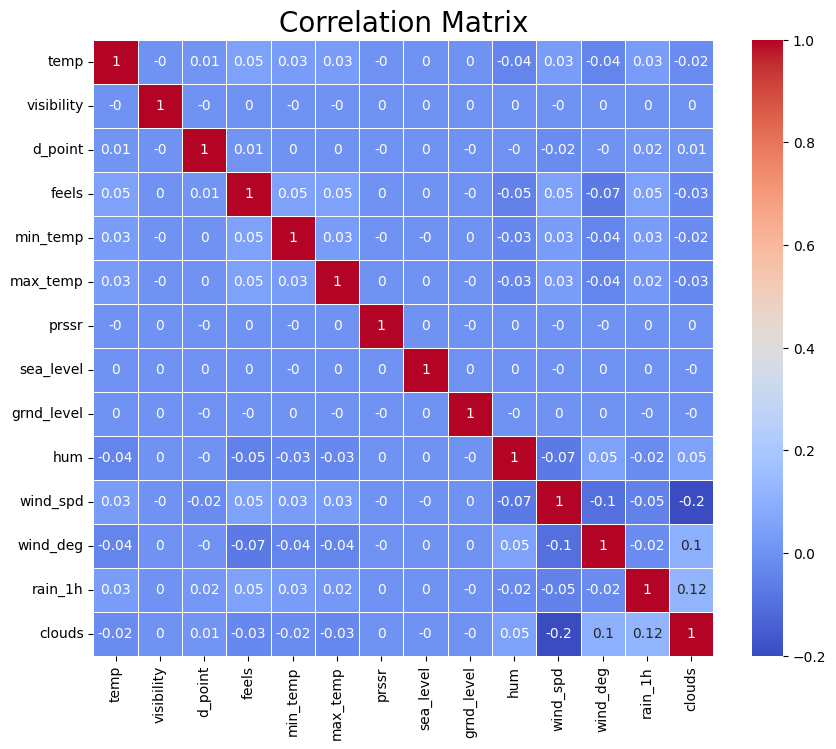

In [ ]:
# melihat korelasi antar kolom
plt.figure(figsize=(10, 8))
correlation_matrix = train.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix", size=20)

dari matriks korelasi diatas terlihat bahwa kolom 'visibility', 'prssr', 'sea_level', dan 'grnd_level' memiliki korelasi sebesar 0 ini berarti kolom tersebut tidak memiliki pengaruh yang berarti terhadap target 'rain_1h' sehingga kolom tersebut dapat didrop

In [ ]:
train.drop(['visibility', 'prssr', 'sea_level','grnd_level'], axis=1, inplace=True)

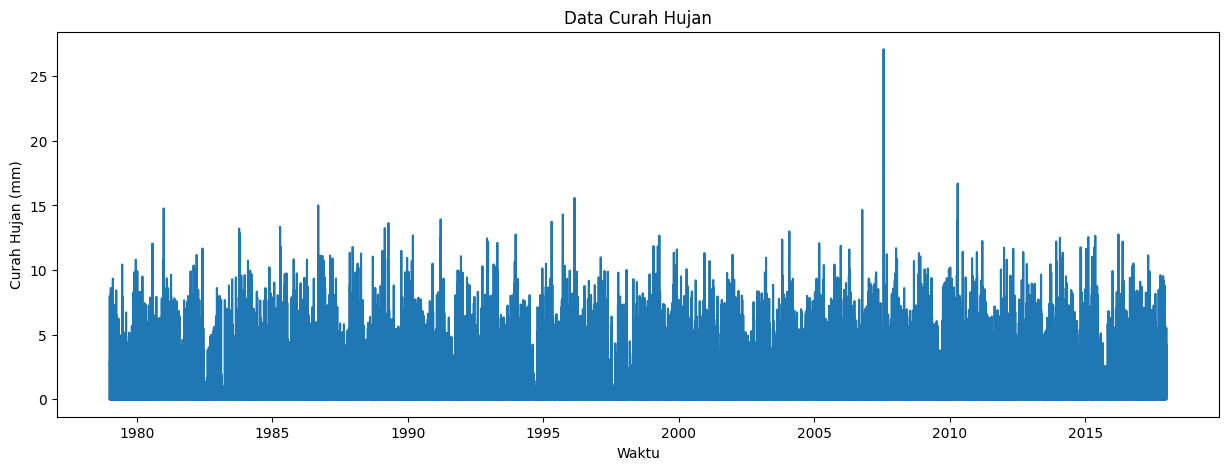

In [ ]:
# melihat tren pola curah hujan 'rain_1h'
plt.figure(figsize=(15,5))
plt.plot(train.index, train['rain_1h'])
plt.xlabel('Waktu')
plt.ylabel('Curah Hujan (mm)')
plt.title('Data Curah Hujan')
plt.show()

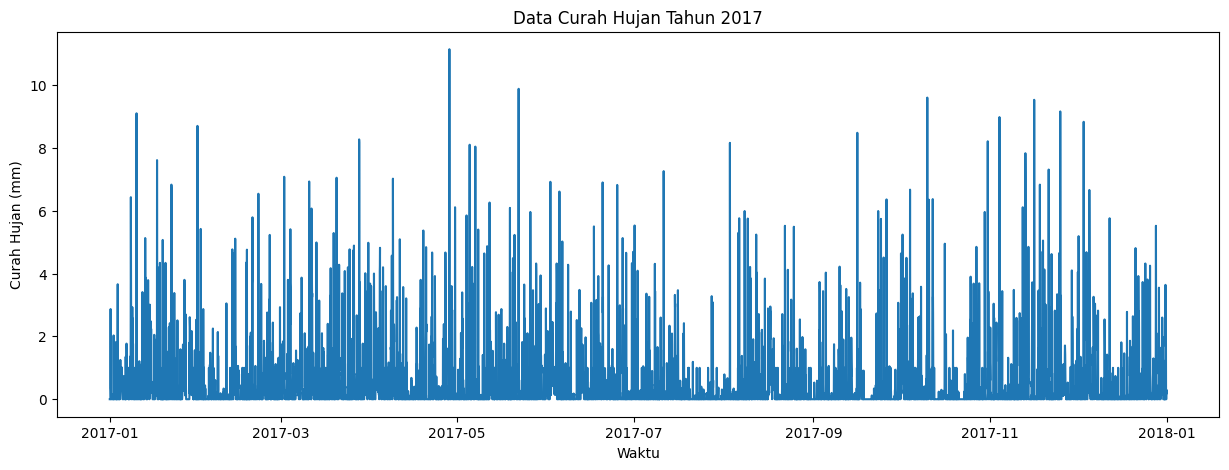

In [ ]:
# melihat tren curah hujan dalam 1 tahun terakhir
year_to_plot = '2017'
filtered_data = train.loc[train.index.year == int(year_to_plot)]
plt.figure(figsize=(15, 5))
plt.plot(filtered_data.index, filtered_data['rain_1h'])
plt.xlabel('Waktu')
plt.ylabel('Curah Hujan (mm)')
plt.title('Data Curah Hujan Tahun ' + year_to_plot)
plt.show()

In [ ]:
train.to_csv('pre-processed_train.csv')

# modelling

In [ ]:
X = train.drop(["rain_1h"], axis=1)
y = train["rain_1h"]

# membagi data untuk train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

X.shape

(341880, 9)

In [ ]:
X_train.shape

(307692, 9)

In [ ]:
!pip install --upgrade lightgbm

In [ ]:
# Membuat dataset LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parameter untuk model LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'subsample': 0.7, 'num_leaves': 310, 'min_child_samples': 180,
    'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.7
}

# Melatih model LightGBM
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Memprediksi nilai target pada data pengujian
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Menghitung RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 307692, number of used features: 9
[LightGBM] [Info] Start training from score 0.370267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 0.8744872638099089


In [ ]:
# simpan model kedalam file pickel
joblib.dump(bst, 'LGBM.pkl')

['LGBM.pkl']

# Submission

In [ ]:
test_path = Path("drive/My Drive/airnology/test.csv")
submission = pd.read_csv(test_path, parse_dates=['datetime_iso'], index_col='datetime_iso')
submission.head()

,datetime,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_3h,snow_1h,snow_3h,clouds
datetime_iso,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,1514764800,28800,26.59 °C,NaN,23.66,26.59,26.02,27.16,1009,NaN,undetermined,84,1.45 m/s,355,0,NaN,no_snow,97
2018-01-01 01:00:00+00:00,1514768400,28800,26.51 C,NaN,24.92,26.51 °C,26.06,28.04,1009,NaN,undetermined,91,1.67 m/s,351,0mm,no-snow,0 milimeter,95
2018-01-01 02:00:00+00:00,1514772000,28800,28.68 C,NaN,25.71,34.68,28.03 C,29.3 C,1009.0 hPa.,NaN,NaN,84,1.72 m/s,345.0°,0 mm,volume:zero,0,90
2018-01-01 03:00:00+00:00,1514775600,28800,28.84 C,NaN,25.25,34.51,28.52,29.08 °C,1008,NaN,NaN,81,1.49,339.0°,0 milimeter,0,NaN,91
2018-01-01 04:00:00+00:00,1514779200,28800,29.75 Celcius,,24.62,35.38,29.31 C,30.57,1007,undetermined,undetermined,74,1.39 m/s,339.0°,NaN,0,volume:0,96


In [ ]:
submission.drop(['visibility', 'prssr', 'sea_level','grnd_level','rain_3h', 'snow_1h', 'snow_3h'], axis=1, inplace=True)
submission

,datetime,time-zone,temp,d_point,feels,min_temp,max_temp,hum,wind_spd,wind_deg,clouds
datetime_iso,,,,,,,,,,,
2018-01-01 00:00:00+00:00,1514764800,28800,26.59 °C,23.66,26.59,26.02,27.16,84,1.45 m/s,355,97
2018-01-01 01:00:00+00:00,1514768400,28800,26.51 C,24.92,26.51 °C,26.06,28.04,91,1.67 m/s,351,95
2018-01-01 02:00:00+00:00,1514772000,28800,28.68 C,25.71,34.68,28.03 C,29.3 C,84,1.72 m/s,345.0°,90
2018-01-01 03:00:00+00:00,1514775600,28800,28.84 C,25.25,34.51,28.52,29.08 °C,81,1.49,339.0°,91
2018-01-01 04:00:00+00:00,1514779200,28800,29.75 Celcius,24.62,35.38,29.31 C,30.57,74,1.39 m/s,339.0°,96
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 19:00:00+00:00,1692471600,28800,24.37 C,23.34,25.32,22.7°C,28.2 °C,94,1.57,239.0°,84
2023-08-19 20:00:00+00:00,1692475200,28800,23.87 C,23.02,24.79 C,21.91,28.01 °C,95,1.53,235.0°,70
2023-08-19 21:00:00+00:00,1692478800,28800,23.87 Celcius,23.02,24.79,21.91,28.01,95.00%,1.53 m/s,235,70


## Cleaning

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49368 entries, 2018-01-01 00:00:00+00:00 to 2023-08-19 23:00:00+00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   49368 non-null  int64 
 1   time-zone  49368 non-null  int64 
 2   temp       49368 non-null  object
 3   d_point    49367 non-null  object
 4   feels      49368 non-null  object
 5   min_temp   49368 non-null  object
 6   max_temp   49368 non-null  object
 7   hum        49368 non-null  object
 8   wind_spd   49368 non-null  object
 9   wind_deg   49368 non-null  object
 10  clouds     49368 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.5+ MB


In [ ]:
# Menggunakan ekspresi reguler untuk membersihkan kolom 'temp' dan mengonversi ke float
submission['temp'] = submission['temp'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
submission['temp'] = submission['temp'].apply(lambda x: float(x[0]) if x else 0.0)

# Menggunakan ekspresi reguler untuk membersihkan kolom 'd_point' dan mengonversi ke float
submission['d_point'] =submission['d_point'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', str(x)))
submission['d_point'] = submission['d_point'].apply(lambda x: float(x[0]) if x else 0.0)

# Menggunakan ekspresi reguler untuk membersihkan kolom 'feels' dan mengonversi ke float
submission['feels'] = submission['feels'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
submission['feels'] = submission['feels'].apply(lambda x: float(x[0]) if x else 0.0)

# Menggunakan ekspresi reguler untuk membersihkan kolom 'min_temp' dan mengonversi ke float
submission['min_temp'] = submission['min_temp'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
submission['min_temp'] = submission['min_temp'].apply(lambda x: float(x[0]) if x else 0.0)

# Menggunakan ekspresi reguler untuk membersihkan kolom 'max_temp' dan mengonversi ke float
submission['max_temp'] = submission['max_temp'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
submission['max_temp'] = submission['max_temp'].apply(lambda x: float(x[0]) if x else 0.0)

# Menggunakan ekspresi reguler untuk membersihkan kolom 'hum' dan mengonversi ke float
submission['hum'] = submission['hum'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
submission['hum'] = submission['hum'].apply(lambda x: float(x[0]) if x else 0.0)

# Menggunakan ekspresi reguler untuk mengambil angka dari kolom 'wind_spd'
submission['wind_spd'] = submission['wind_spd'].apply(lambda x: re.search(r'[\d.]+', x).group() if re.search(r'[\d.]+', x) else '0')
# Mengonversi kolom 'wind_spd' menjadi tipe data float
submission['wind_spd'] = submission['wind_spd'].astype(float)

# Menggunakan ekspresi reguler untuk membersihkan kolom 'wind_deg' dan mengonversi ke float
submission['wind_deg'] = submission['wind_deg'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
submission['wind_deg'] = submission['wind_deg'].apply(lambda x: float(x[0]) if x else 0.0)

# Menggunakan ekspresi reguler untuk membersihkan kolom 'clouds' dan mengonversi ke float
submission['clouds'] = submission['clouds'].apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
submission['clouds'] = submission['clouds'].apply(lambda x: float(x[0]) if x else 0.0)

In [ ]:
submission

,datetime,time-zone,temp,d_point,feels,min_temp,max_temp,hum,wind_spd,wind_deg,clouds
datetime_iso,,,,,,,,,,,
2018-01-01 00:00:00+00:00,1514764800,28800,26.59,23.66,26.59,26.02,27.16,84.0,1.45,355.0,97.0
2018-01-01 01:00:00+00:00,1514768400,28800,26.51,24.92,26.51,26.06,28.04,91.0,1.67,351.0,95.0
2018-01-01 02:00:00+00:00,1514772000,28800,28.68,25.71,34.68,28.03,29.30,84.0,1.72,345.0,90.0
2018-01-01 03:00:00+00:00,1514775600,28800,28.84,25.25,34.51,28.52,29.08,81.0,1.49,339.0,91.0
2018-01-01 04:00:00+00:00,1514779200,28800,29.75,24.62,35.38,29.31,30.57,74.0,1.39,339.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 19:00:00+00:00,1692471600,28800,24.37,23.34,25.32,22.70,28.20,94.0,1.57,239.0,84.0
2023-08-19 20:00:00+00:00,1692475200,28800,23.87,23.02,24.79,21.91,28.01,95.0,1.53,235.0,70.0
2023-08-19 21:00:00+00:00,1692478800,28800,23.87,23.02,24.79,21.91,28.01,95.0,1.53,235.0,70.0


In [ ]:
submission.to_csv('Pre-processed_test.csv', index=False)

In [ ]:
submission.drop(['datetime',"time-zone"], axis=1, inplace=True)

In [ ]:
test_result = bst.predict(submission, num_iteration=bst.best_iteration)

In [ ]:
new_submission = pd.read_csv(test_path)
new_submission = new_submission["datetime_iso"]

In [ ]:
submission = pd.DataFrame({'datetime_iso': new_submission, 'rain_1h': test_result})

In [ ]:
submission.to_csv('LGBM.csv', index=False)